In [1]:
import numpy as np
import pandas as pd   
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
df = pd.read_csv("Data/data_pre.csv")
df = df.dropna()
df = df.drop(columns=['Unnamed: 0','CARRIER_DELAY'])

In [3]:
y = df.DEP_DELAY
dates = df.FL_DATE
X = df.drop(["DEP_DELAY"],axis=1)
X["FL_DATE"] = pd.to_datetime(X["FL_DATE"]).dt.dayofyear
# Convert DEP_TIME to integer hour
X["DEP_TIME"] = pd.to_datetime(X["DEP_TIME"]).dt.hour
X

,FL_DATE,DEP_TIME,TAXI_OUT,TEMP,WIND,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_US,OP_CARRIER_United Airlines
0,1,22,18.0,34.7,12.4,0,0,0,1,0,0,0,0,0,0
10,1,15,18.0,38.7,13.2,0,0,0,1,0,0,0,0,0,0
15,1,11,29.0,36.7,13.1,0,0,0,1,0,0,0,0,0,0
20,1,13,27.0,38.4,13.2,0,0,0,0,0,0,0,1,0,0
22,1,20,57.0,35.7,13.0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54152,181,8,31.0,73.1,9.3,0,0,0,0,0,0,0,1,0,0
54153,181,21,30.0,71.8,9.6,0,0,0,0,0,0,0,1,0,0
54155,181,9,16.0,75.0,9.7,0,0,0,0,0,0,0,1,0,0
54157,181,15,34.0,78.6,13.7,0,0,0,0,0,0,0,1,0,0


In [4]:
# Try very little subset of data
Xnn = X
ynn = y

# Make split
X_train, X_test, y_train, y_test = train_test_split(Xnn, ynn, test_size=0.33, random_state=42)

In [5]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [6]:
########### Try Neural Network model
Xnn = torch.tensor(Xnn.to_numpy()).float()
ynn = torch.tensor(ynn.to_numpy()).float()

In [7]:

class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden,n_hidden2, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden2)
        self.h_layer2 = torch.nn.Linear(n_hidden2, n_hidden2)
        self.h_layer3 = torch.nn.Linear(n_hidden2, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.sig = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p=0.2)
        
    def forward(self, X):
        # Forward pass
        X = self.sig(self.in_layer(X))
        X = self.sig(self.h_layer(X))
        X = self.dropout(X)
        X = self.sig(self.h_layer2(X))
        X = self.dropout(X)
        X = self.sig(self.h_layer3(X))
        X = self.out_layer(X)
        
        return X

In [8]:
def nnet_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=30,n_hidden2=40, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
        
    return y

In [9]:
# Define guide function
guide = AutoDiagonalNormal(nnet_model)

# Reset parameter values
pyro.clear_param_store()

In [10]:
# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(Xnn, ynn)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

c:\Users\chris\anaconda3\lib\site-packages\pyro\primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(


[0] ELBO: 4123045635.8
[500] ELBO: 2144085283.1
[1000] ELBO: 1733757691.4
[1500] ELBO: 1596542367.5
[2000] ELBO: 1536117408.4
[2500] ELBO: 1516629236.2
[3000] ELBO: 1508248070.6
[3500] ELBO: 1496401144.5
[4000] ELBO: 1480883832.0
[4500] ELBO: 1468603922.7
[5000] ELBO: 1458837078.4
[5500] ELBO: 1449051427.3
[6000] ELBO: 1436333181.9
[6500] ELBO: 1430794738.4
[7000] ELBO: 1420694757.7
[7500] ELBO: 1414164259.6
[8000] ELBO: 1429547098.6
[8500] ELBO: 1416122622.5
[9000] ELBO: 1412621159.4
[9500] ELBO: 1410427444.6
[10000] ELBO: 1420740073.3
[10500] ELBO: 1406883120.0
[11000] ELBO: 1395026141.9
[11500] ELBO: 1404736743.3


In [11]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test.to_numpy()).float()

In [12]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

CorrCoef: 0.618
MAE: 34.567
RMSE: 48.693
R2: 0.380


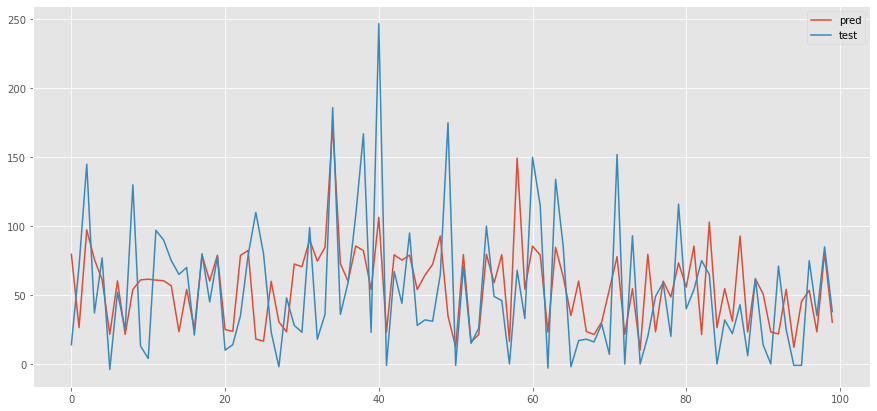

In [13]:
y_pred = samples["obs"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, r2 = compute_error(y_test, y_pred)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

# Save results in new variables
y_t = y_test
y_p = y_pred

# Drop index
y_t = y_t.reset_index().drop('index',axis=1)

# Plot
fig = plt.subplots(1,figsize=(15,7))
plt.plot(y_p[:100],label='pred')
plt.plot(y_t[:100],label='test')
plt.legend()

In [32]:
def nnet_interpretable_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=20,n_hidden2=30, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # Linear model priors
    beta_lin = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1])).to_event())
    # The generative process
    with pyro.plate("observations"):
        linear_out = torch.matmul(X,beta_lin)
        nn_out = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Normal(linear_out+nn_out, 0.1), obs=y)
        
    return y

In [33]:
# Define guide function
guide = AutoDiagonalNormal(nnet_interpretable_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_interpretable_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(Xnn, ynn)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 2926129733.9
[500] ELBO: 1900582560.8
[1000] ELBO: 1759995855.4
[1500] ELBO: 1605994799.6
[2000] ELBO: 1556957045.3
[2500] ELBO: 1536043072.2
[3000] ELBO: 1558746953.7
[3500] ELBO: 1520901043.1
[4000] ELBO: 1498830151.9
[4500] ELBO: 1475819309.7
[5000] ELBO: 1478017897.9
[5500] ELBO: 1452900893.3
[6000] ELBO: 1448702841.1
[6500] ELBO: 1442068486.8
[7000] ELBO: 1427153193.6
[7500] ELBO: 1404620702.3
[8000] ELBO: 1381670961.5
[8500] ELBO: 1362521260.6
[9000] ELBO: 1362503464.9
[9500] ELBO: 1333131531.6


In [34]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

CorrCoef: 0.634
MAE: 34.556
RMSE: 47.913
R2: 0.400


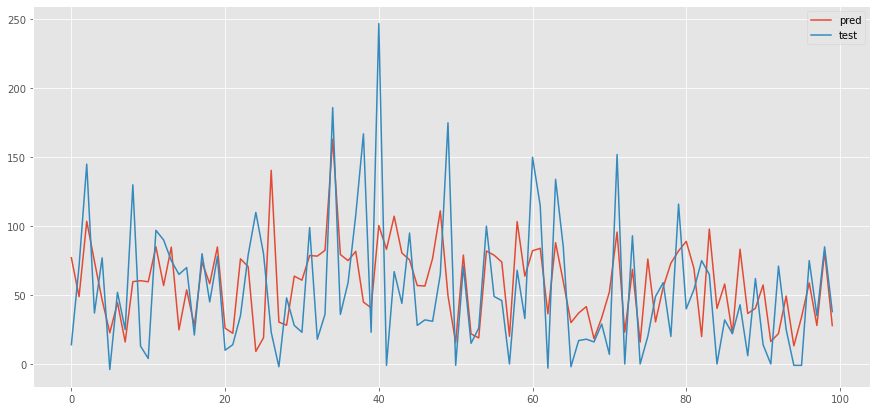

In [35]:
y_pred = samples["obs"].mean(axis=0).detach().numpy()

corr, mae, rae, rmse, r2 = compute_error(y_test, y_pred)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

# Save results in new variables
y_t = y_test
y_p = y_pred

# Drop index
y_t = y_t.reset_index().drop('index',axis=1)

# Plot
fig = plt.subplots(1,figsize=(15,7))
plt.plot(y_p[:100],label='pred')
plt.plot(y_t[:100],label='test')
plt.legend()

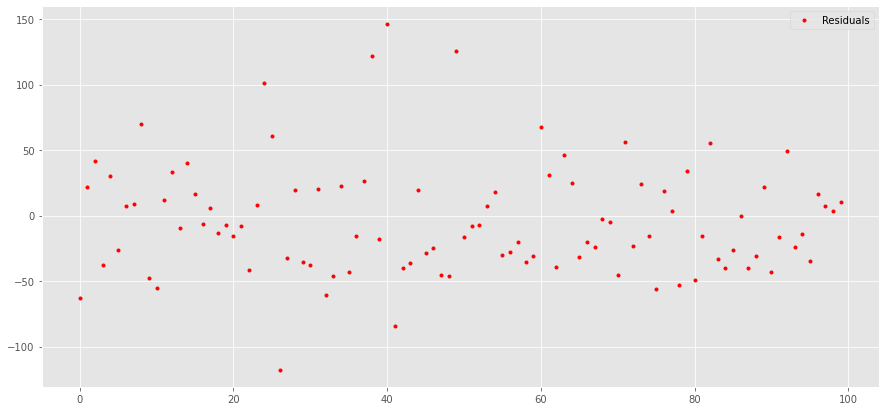

In [50]:
# Plot
fig = plt.subplots(1,figsize=(15,7))
plt.plot(y_t[:100].to_numpy().ravel()-y_p[:100],'.r',label='Residuals')
plt.legend()

In [51]:
np.mean(y_t[:100].to_numpy().ravel()-y_p[:100])

-4.497853889465332